In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imutils

from tensorflow.keras.models import load_model
from imutils.contours import sort_contours

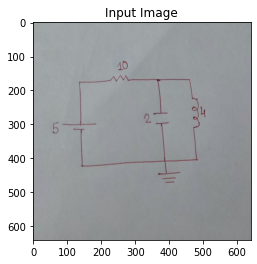

In [2]:
# Loading a test image
testCCT = cv2.imread("testCCTs/cct1.jpeg")
testCCT = cv2.resize(testCCT, (640, 640))
plt.imshow(testCCT)
plt.title('Input Image')
plt.show()

In [3]:
# Loading training model from STEP1
model = load_model('models/trained_MNIST_model')

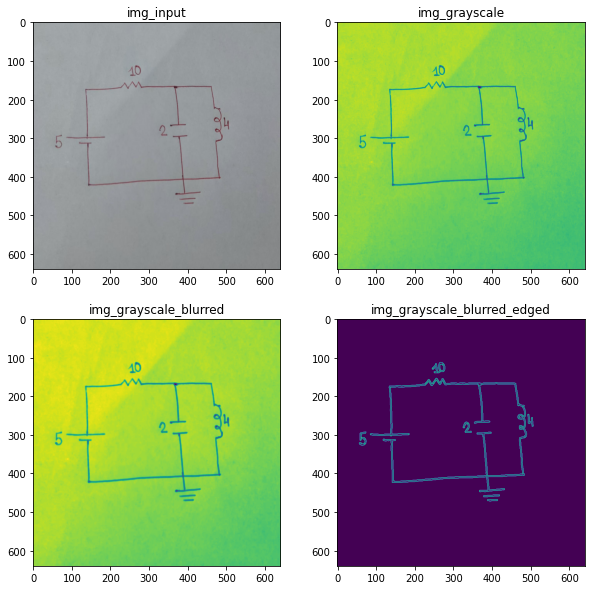

In [4]:
# Preprocessing Image for Contours
img = testCCT
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 30, 150)

# Visualizing Preprocessing Dataset
row = 2
col = 2
fig, axes = plt.subplots(row, col, figsize=(10,10))

axes[0, 0].imshow(img)
axes[0, 0].set_title("img_input")

axes[0, 1].imshow(gray)
axes[0, 1].set_title("img_grayscale")

axes[1, 0].imshow(blurred)
axes[1, 0].set_title("img_grayscale_blurred")

axes[1, 1].imshow(edged)
axes[1, 1].set_title("img_grayscale_blurred_edged")

plt.show()

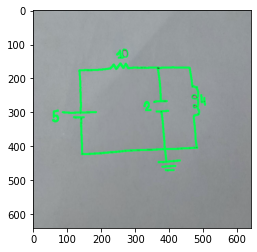

In [5]:
# Finding contours
contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
contours = sort_contours(contours, method="left-to-right")[0]

# Drawing contours
plt.imshow(cv2.drawContours(img, contours, -1, (0,255,75), 2))

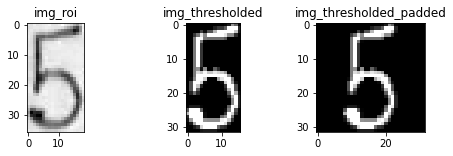

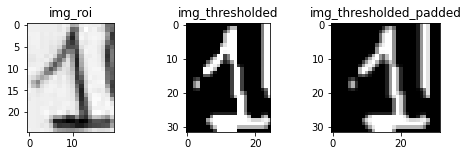

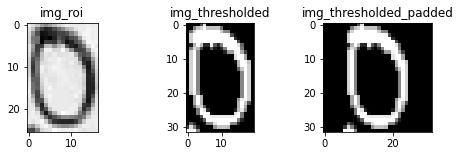

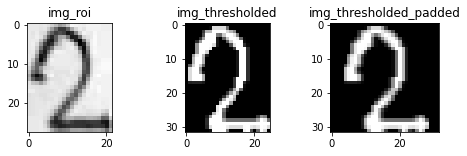

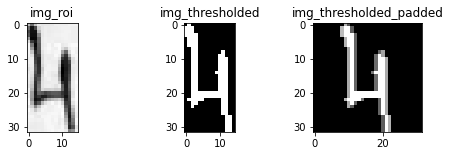

In [6]:
characters = []

for contour in contours:
    # Bounding contours by rectangles
    (x, y, w, h) = cv2.boundingRect(contour)

    # Limiting to text contours only
    if (w >= 3 and w <= 50) and (h >= 15 and h <= 50):

        roi = gray[y : y + h, x : x + w]

        ret,thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
        (tH, tW) = thresh.shape

        # If width is greater
        if tW > tH:
            # Resize along width
            thresh = imutils.resize(thresh, width=32)
        else:
            # Otherwise, Resize along the height
            thresh = imutils.resize(thresh, height=32)

        (tH, tW) = thresh.shape
        dX = int(max(0, 32 - tW) / 2.0)
        dY = int(max(0, 32 - tH) / 2.0)

        # Pad the image and force 32x32 dimensions
        padded = cv2.copyMakeBorder(
            thresh,
            top=dY,
            bottom=dY,
            left=dX,
            right=dX,
            borderType=cv2.BORDER_CONSTANT,
            value=(0, 0, 0),
        )
        padded = cv2.resize(padded, (32, 32))

        # Visualizing Thresholding and Padding
        row = 1
        col = 3
        fig, axes = plt.subplots(row, col, figsize=(8,2))

        axes[0].imshow(roi, "gray")
        axes[0].set_title("img_roi")

        axes[1].imshow(thresh, "gray")
        axes[1].set_title("img_thresholded")

        axes[2].imshow(padded, "gray")
        axes[2].set_title("img_thresholded_padded")

        plt.show()

        # Prepare the padded image for classification via our MNIST model
        padded = padded.astype("float32") / 255.0
        padded = np.expand_dims(padded, axis=-1)

        # Update our list of characters that will be OCR'd
        characters.append((padded, (x, y, w, h)))

2021-12-29 18:40:05.314574: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


[[(57, 293, 19, 36), 5], [(245, 117, 20, 25), 1], [(262, 114, 17, 26), 0], [(325, 268, 22, 28), 2], [(492, 248, 15, 32), 4]]


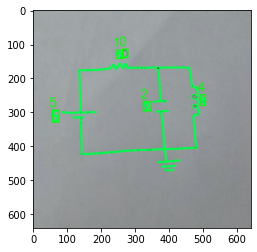

In [7]:
boxes = [b[1] for b in characters]

chars = np.array([c[0] for c in characters], dtype="float32")

# OCR the characters using our handwriting recognition model
preds = model.predict(chars)

# Define the list of label names
labelNames = "0123456789"
labelNames = [l for l in labelNames]

boxes_val = []

for (pred, (x, y, w, h)) in zip(preds, boxes):
    # Find the index of the label with the largest corresponding probability, 
    # Then Extract the probability and label
    i = np.argmax(pred)
    prob = pred[i]
    label = labelNames[i]

    # Putting a text box on image output
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(img, label, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
    boxes_val.append([(x, y, w, h), int(label)])

print(boxes_val)
plt.imshow(img)


In [8]:
# Combining close ranged boxes
bvcpy = boxes_val.copy()
n = 1

for i in range(len(bvcpy) - 2, -1, -1):
    # Getting points for the two boxes
    x1 = bvcpy[i][0][0]
    y1 = bvcpy[i][0][1]
    x2 = bvcpy[i + 1][0][0]
    y2 = bvcpy[i + 1][0][1]
    w1 = bvcpy[i][0][2]
    h1 = bvcpy[i][0][3]
    w2 = bvcpy[i + 1][0][2]
    h2 = bvcpy[i + 1][0][3]

    # Calculating distance
    dist = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

    # If distance is less
    if dist <= 50:
        # Modifying the boxes endpoints
        boxes_val[i][0] = (
            x1,
            min(y1, y2),
            x2 - x1 + w2,
            max(y1 + h1, y2 + h2) - min(y1, y2),
        )
        # Updating box value
        boxes_val[i][1] = (10 ** n) * boxes_val[i][1] + boxes_val[i + 1][1]

        # Removing redundant box
        boxes_val.remove(boxes_val[i + 1])
        n = n + 1
    else:
        n = 1


In [9]:
# Final predicted characters
print(boxes_val)

[[(57, 293, 19, 36), 5], [(245, 114, 34, 28), 10], [(325, 268, 22, 28), 2], [(492, 248, 15, 32), 4]]
